In [2]:
%pip install statsmodels
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,learning_curve
from sklearn.metrics import silhouette_samples, silhouette_score,calinski_harabasz_score,adjusted_rand_score, mutual_info_score
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.random_projection import GaussianRandomProjection
from sklearn.decomposition import PCA, FastICA
from sklearn.mixture import GaussianMixture
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
from sklearn.manifold import Isomap
import itertools


from tqdm import tqdm
import time
from sklearn.metrics import mean_squared_error
import os
from scipy.stats import kurtosis

import cv2
import glob

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED);

DEPRECATION: Loading egg at /Users/timlampen/.pyenv/versions/3.12.2/lib/python3.12/site-packages/Box2D-2.3.10-py3.12-macosx-14.3-arm64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
def get_bank_data():
    df = pd.read_csv("bank/bank-full.csv",delimiter=';')

    # Convert numerical columns to the correct data type
    df["age"] = df["age"].astype(int)
    df["balance"] = df["balance"].astype(int)
    df["day"] = df["day"].astype(int)
    df["duration"] = df["duration"].astype(int)
    df["campaign"] = df["campaign"].astype(int)
    df["pdays"] = df["pdays"].astype(int)
    df["previous"] = df["previous"].astype(int)
    df["y"] = [0 if y=="no" else 1 for y in df["y"]]

    # Separate features and target
    X_raw = df.drop(columns=["y"])
    y = df["y"]

    # Define which columns are numerical and which are categorical
    numerical_features = ["age", "balance", "day", "duration", "campaign", "pdays", "previous"]
    categorical_features = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "poutcome"]

    # Create a column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numerical_features),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
        ]
    )

    # Create a preprocessing and modeling pipeline
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor)
    ])

    # Fit and transform the data
    X = pipeline.fit_transform(X_raw)

    return X, y, preprocessor

In [4]:
def get_trash_data(folder, image_size):
    images = []
    labels = []
    class_names = []
    class_idx = 0

    for class_folder in tqdm(os.listdir(folder)):
        class_path = os.path.join(folder, class_folder)
        if not os.path.isdir(class_path):
            continue

        class_names.append(class_folder)
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, image_size)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                images.append(img.flatten())
                labels.append(class_idx)
        
        class_idx += 1
    print(f"Loaded {len(images)} images.")
    return np.array(images), np.array(labels), class_names

In [5]:
def plot_silhouette(n_clusters, sample_silhouette_values, cluster_labels, silhouette_avg):
   # Create a subplot with 1 row and 1 column
    fig, ax1 = plt.subplots(1, 1)

    # The silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(cluster_labels) + (n_clusters + 1) * 10])

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the y-axis labels / ticks
    ax1.set_xticks([i / 10.0 for i in range(-1, 11)])

    plt.show()

In [6]:
X_bank, y_bank, preprocessor = get_bank_data()
X_waste, y_waste, _ = get_trash_data("realwaste-main/RealWaste", (64,64))

X_train_bank, X_test_bank, y_train_bank, y_test_bank = train_test_split(X_bank, y_bank, test_size=0.2, random_state=RANDOM_SEED)
X_train_waste, X_test_waste, y_train_waste, y_test_waste = train_test_split(X_waste, y_waste, test_size=0.2, random_state=RANDOM_SEED)


training_data = {
    "bank_marketing": {
        "X": X_train_bank,
        "y": y_train_bank
    },
    "real_waste": {
        "X": X_train_waste,
        "y": y_train_waste
    }
}

testing_data = {
    "bank_marketing": {
        "X": X_test_bank,
        "y": y_test_bank
    },
    "real_waste": {
        "X": X_test_waste,
        "y": y_test_waste
    }
}


100%|██████████| 9/9 [00:09<00:00,  1.09s/it]

Loaded 4752 images.


In [12]:
print(f"Bank Marketing matrix rank: {np.linalg.matrix_rank(X_bank)}")
print(f"Real Waste matrix rank: {np.linalg.matrix_rank(X_waste)}")

Bank Marketing matrix rank: 43
Real Waste matrix rank: 4096


In [50]:
repeats = list(range(0,5))
datasets = ["real_waste", "bank_marketing"]
num_clusters_range = range(2, 11, 2)
models = [("KMeans", KMeans), ("EM", GaussianMixture)]

output = []

for _, dataset_name, num_clusters, (model_name, Model) in tqdm(list(itertools.product(repeats, datasets, num_clusters_range, models))):
    X_train = training_data[dataset_name]["X"]
    
    start_time = time.time()
    model = Model(num_clusters)
    y_pred = model.fit_predict(X_train)
    fit_duration = time.time() - start_time

    silhouette_avg = silhouette_score(X_train, y_pred)
    calinski_score = calinski_harabasz_score(X_train, y_pred)
    similarity_score = adjusted_rand_score(training_data[dataset_name]["y"], y_pred)

    output.append([dataset_name, model_name, num_clusters, silhouette_avg, calinski_score, fit_duration, similarity_score])

output_df = pd.DataFrame(output, columns=["dataset_name", "model_name", "num_clusters", "silhouette_avg", "calinski_score", "fit_duration", "similarity_score"])
output_df.to_csv(f"clustering_evaluation_{time.time()}.csv")

100%|██████████| 100/100 [29:05<00:00, 17.46s/it]


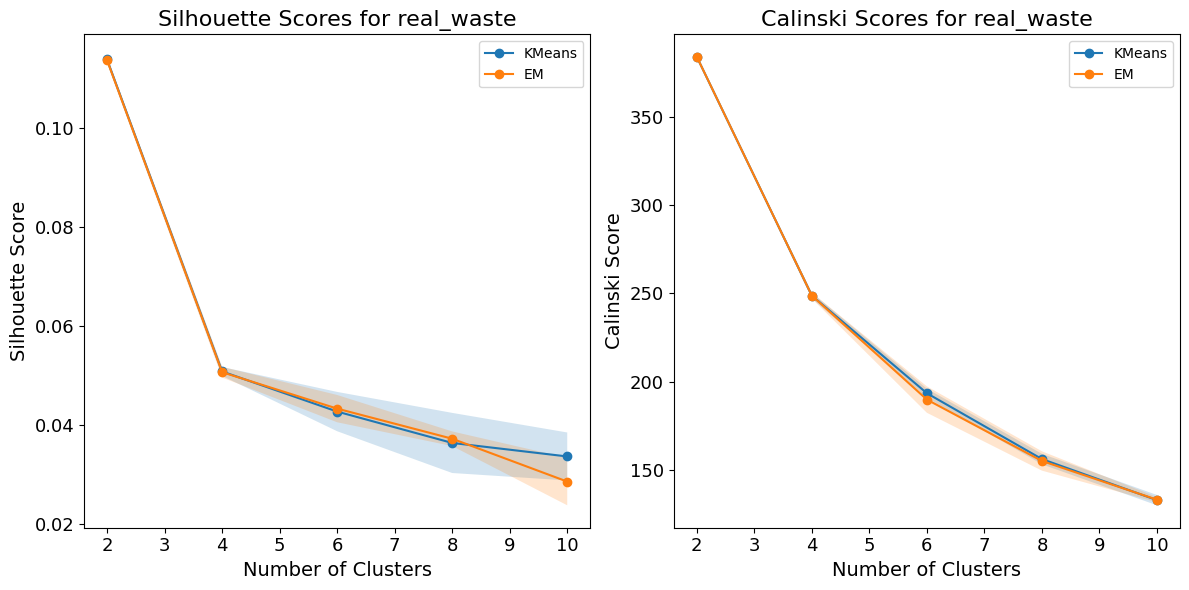

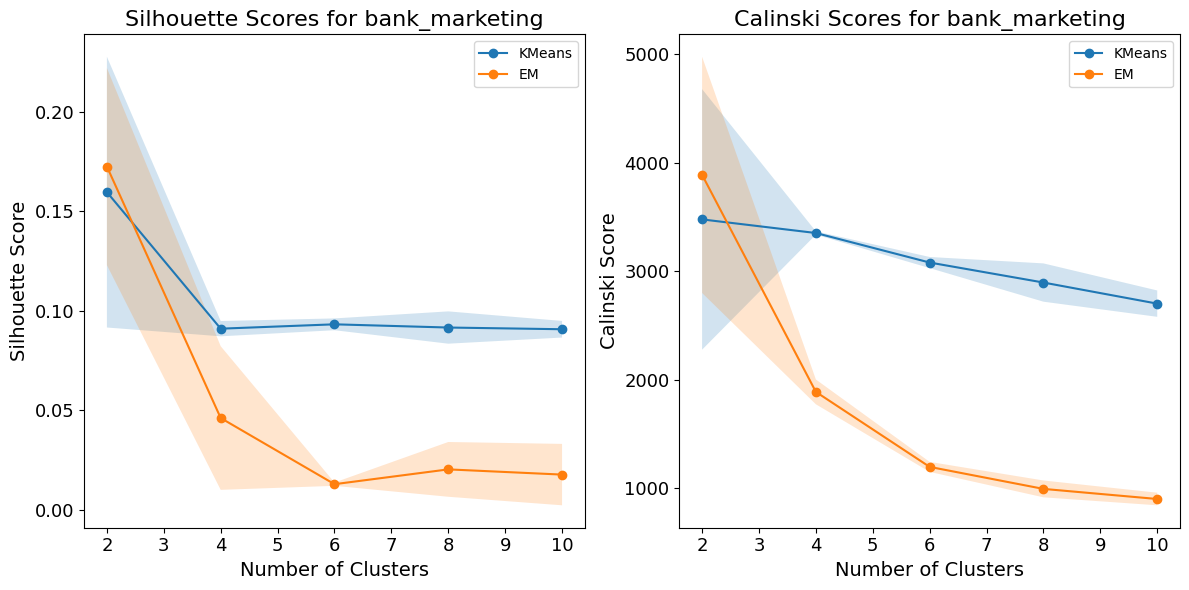

In [53]:
files = glob.glob('clustering_evaluation_*.csv')
latest_file = max(files, key=lambda x: int(x.split('_')[-1].split('.')[0]))
result_df = pd.read_csv(latest_file)

# Function to generate the graphs
def plot_silhouette_and_calinski_scores(df):
    # Get the unique dataset names
    dataset_names = df['dataset_name'].unique()
    
    for dataset in dataset_names:
        # Filter the dataframe by dataset name
        subset = df[df['dataset_name'] == dataset]
        
        # Create subplots
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        
        # Plot the silhouette scores
        for model_name in subset['model_name'].unique():
            model_subset = subset[subset['model_name'] == model_name]
            means = model_subset.groupby('num_clusters')['silhouette_avg'].mean()
            variances = model_subset.groupby('num_clusters')['silhouette_avg'].var()
            std_dev = variances ** 0.5
            axs[0].plot(means.index, means, marker='o', label=model_name)
            axs[0].fill_between(means.index, means - std_dev, means + std_dev, alpha=0.2)
        
        axs[0].set_title(f'Silhouette Scores for {dataset}',fontsize=16)
        axs[0].set_xlabel('Number of Clusters',fontsize=14)
        axs[0].set_ylabel('Silhouette Score',fontsize=14)
        axs[0].tick_params(axis='both', which='major',labelsize=13)
        axs[0].legend()
        
        # Plot the calinski scores
        for model_name in subset['model_name'].unique():
            model_subset = subset[subset['model_name'] == model_name]
            means = model_subset.groupby('num_clusters')['calinski_score'].mean()
            variances = model_subset.groupby('num_clusters')['calinski_score'].var()
            std_dev = variances ** 0.5
            axs[1].plot(means.index, means, marker='o', label=model_name)
            axs[1].fill_between(means.index, means - std_dev, means + std_dev, alpha=0.2)
        
        axs[1].set_title(f'Calinski Scores for {dataset}',fontsize=16)
        axs[1].set_xlabel('Number of Clusters',fontsize=14)
        axs[1].set_ylabel('Calinski Score',fontsize=14)
        axs[1].tick_params(axis='both', which='major',labelsize=13)
        axs[1].legend()
        
        plt.tight_layout()
        plt.show()

plot_silhouette_and_calinski_scores(result_df)

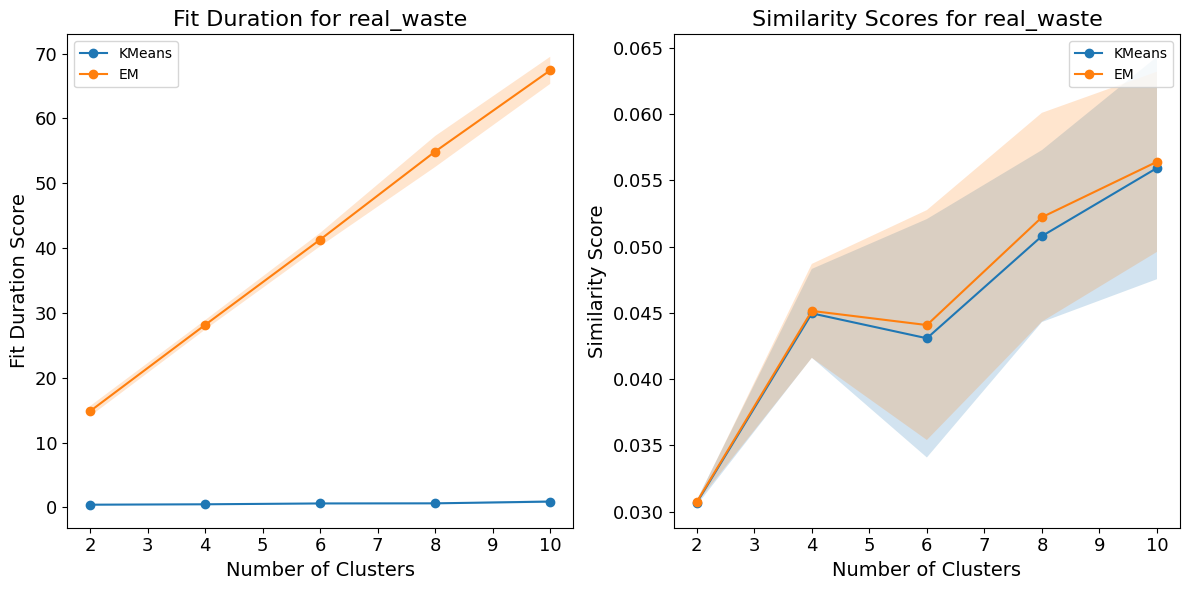

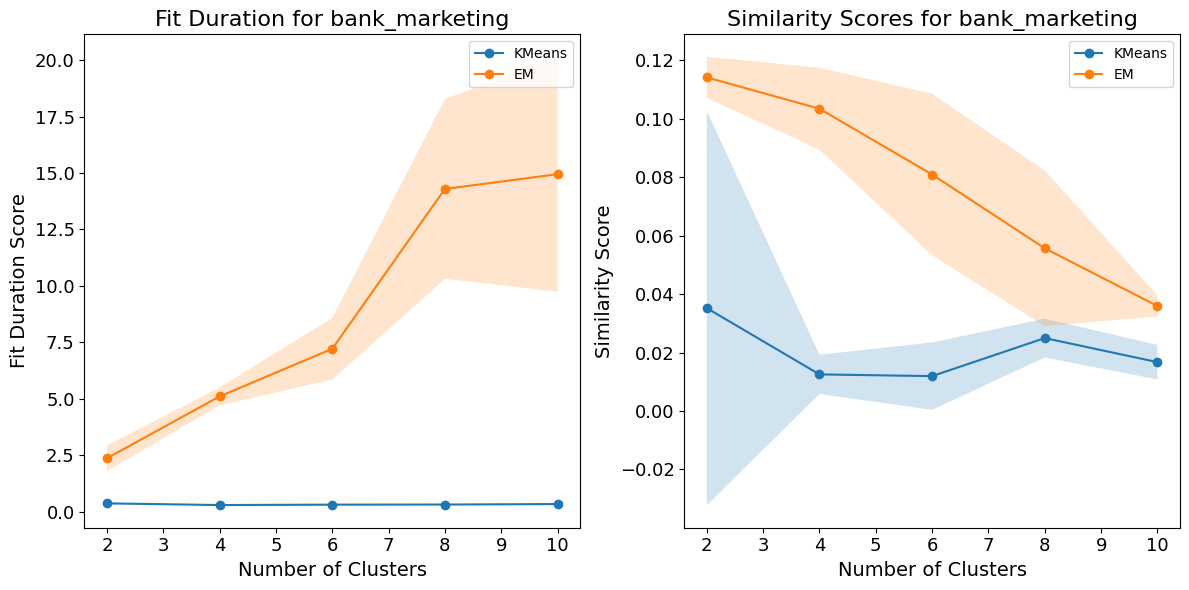

In [54]:
files = glob.glob('clustering_evaluation_*.csv')
latest_file = max(files, key=lambda x: int(x.split('_')[-1].split('.')[0]))
result_df = pd.read_csv(latest_file)

# Function to generate the graphs
def plot_silhouette_and_calinski_scores(df):
    # Get the unique dataset names
    dataset_names = df['dataset_name'].unique()
    
    for dataset in dataset_names:
        # Filter the dataframe by dataset name
        subset = df[df['dataset_name'] == dataset]
        
        # Create subplots
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        
        # Plot the silhouette scores
        for model_name in subset['model_name'].unique():
            model_subset = subset[subset['model_name'] == model_name]
            means = model_subset.groupby('num_clusters')['fit_duration'].mean()
            variances = model_subset.groupby('num_clusters')['fit_duration'].var()
            std_dev = variances ** 0.5
            axs[0].plot(means.index, means, marker='o', label=model_name)
            axs[0].fill_between(means.index, means - std_dev, means + std_dev, alpha=0.2)
        
        axs[0].set_title(f'Fit Duration for {dataset}',fontsize=16)
        axs[0].set_xlabel('Number of Clusters',fontsize=14)
        axs[0].set_ylabel('Fit Duration Score',fontsize=14)
        axs[0].tick_params(axis='both', which='major',labelsize=13)
        axs[0].legend()
        
        # Plot the calinski scores
        for model_name in subset['model_name'].unique():
            model_subset = subset[subset['model_name'] == model_name]
            means = model_subset.groupby('num_clusters')['similarity_score'].mean()
            variances = model_subset.groupby('num_clusters')['similarity_score'].var()
            std_dev = variances ** 0.5
            axs[1].plot(means.index, means, marker='o', label=model_name)
            axs[1].fill_between(means.index, means - std_dev, means + std_dev, alpha=0.2)
        
        axs[1].set_title(f'Similarity Scores for {dataset}',fontsize=16)
        axs[1].set_xlabel('Number of Clusters',fontsize=14)
        axs[1].set_ylabel('Similarity Score',fontsize=14)
        axs[1].tick_params(axis='both', which='major',labelsize=13)
        axs[1].legend()
        
        plt.tight_layout()
        plt.show()

plot_silhouette_and_calinski_scores(result_df)

                n_components
dataset_name                
bank_marketing          24.0
real_waste            1214.0


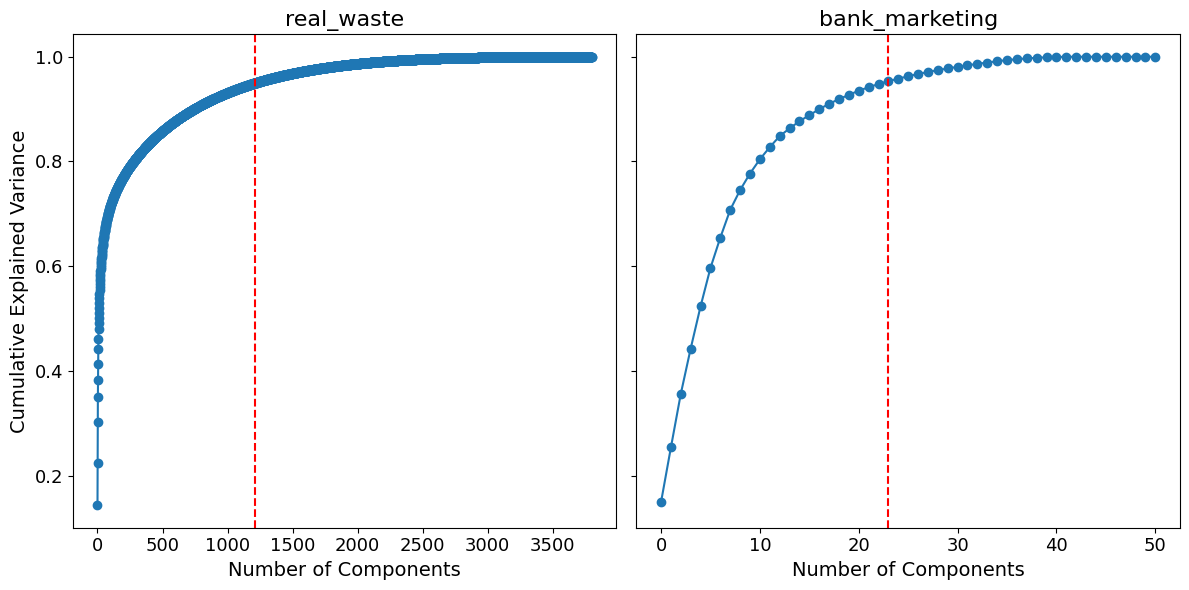

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6),sharey=True)

num_components = []
for repeat in range(0,5):
    for i, dataset_name in enumerate(["real_waste", "bank_marketing"]):
        X_train = training_data[dataset_name]["X"]
        pca = PCA()
        pca.fit(X_train)

        # Explained variance ratio
        explained_variance_ratio = pca.explained_variance_ratio_

        # Cumulative explained variance
        cumulative_explained_variance = np.cumsum(explained_variance_ratio)

        # Determine the number of components for 95% variance
        desired_variance = 0.95
        n_components = np.argmax(cumulative_explained_variance >= desired_variance) + 1
        num_components.append((dataset_name, n_components))
        
        if repeat == 4:
            # Plot cumulative explained variance
            axs[i].plot(cumulative_explained_variance, marker='o')
            axs[i].axvline(x=n_components - 1, color='r', linestyle='--')
            axs[i].set_xlabel('Number of Components',fontsize=14)
            axs[i].tick_params(axis='both', which='major',labelsize=13)

            if i == 0:
                axs[i].set_ylabel('Cumulative Explained Variance',fontsize=14)
            axs[i].set_title(dataset_name,fontsize=16)


print(pd.DataFrame(num_components, columns=["dataset_name", "n_components"]).groupby("dataset_name").mean())

plt.tight_layout()

In [ ]:
output = []

# Function to calculate average raw kurtosis for ICA
def average_raw_kurtosis(components):
    return np.mean(kurtosis(components, axis=0, fisher=False))

for repeat in range(0,5):
    for dataset_name in ["bank_marketing","real_waste"]:
        print(dataset_name)
        X_train = training_data[dataset_name]["X"]

        # Determine the number of components for ICA
        max_kurtosis = 0
        optimal_components = 1
        kurtosis_values = []

        for n in tqdm(np.linspace(1, min(X_train.shape[1]+1,X_train.shape[0]+1),5,dtype=int)):
            ica = FastICA(n_components=n, max_iter=300)
            components = ica.fit_transform(X_train)
            avg_kurt = average_raw_kurtosis(components)
            kurtosis_values.append(avg_kurt)
            
            if avg_kurt > max_kurtosis:
                max_kurtosis = avg_kurt
                optimal_components = n

            output.append([dataset_name, n, avg_kurt])

output_df = pd.DataFrame(output,columns=["dataset_name", "n_components", "avg_kurtosis"])
output_df.to_csv(f"ica_kurtosis_{time.time()}.csv")

In [94]:
X_train = training_data["bank_marketing"]["X"]
ica = FastICA(n_components=13, random_state=RANDOM_SEED,max_iter=300)
ica.fit_transform(X_train)
mixing_matrix = ica.mixing_
first_component_contributions = mixing_matrix[:, 0]
sorted_indices = np.argsort(np.abs(first_component_contributions))[::-1]
categorical_features = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "poutcome"]
# Create a DataFrame for easier interpretation
feature_names = np.array(
    ["age", "balance", "day", "duration", "campaign", "pdays", "previous"] + \
    list(preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_features))
)
contributions_df = pd.DataFrame({
    "Feature": feature_names[sorted_indices],
    "Contribution": first_component_contributions[sorted_indices]
})
contributions_df.sort_values(by="Contribution").head(5)

,Feature,Contribution
0,contact_cellular,-0.433839
4,month_jul,-0.119089
5,month_aug,-0.100662
6,month_nov,-0.058289
7,education_tertiary,-0.049187


bank_marketing - 13
real_waste - 3802


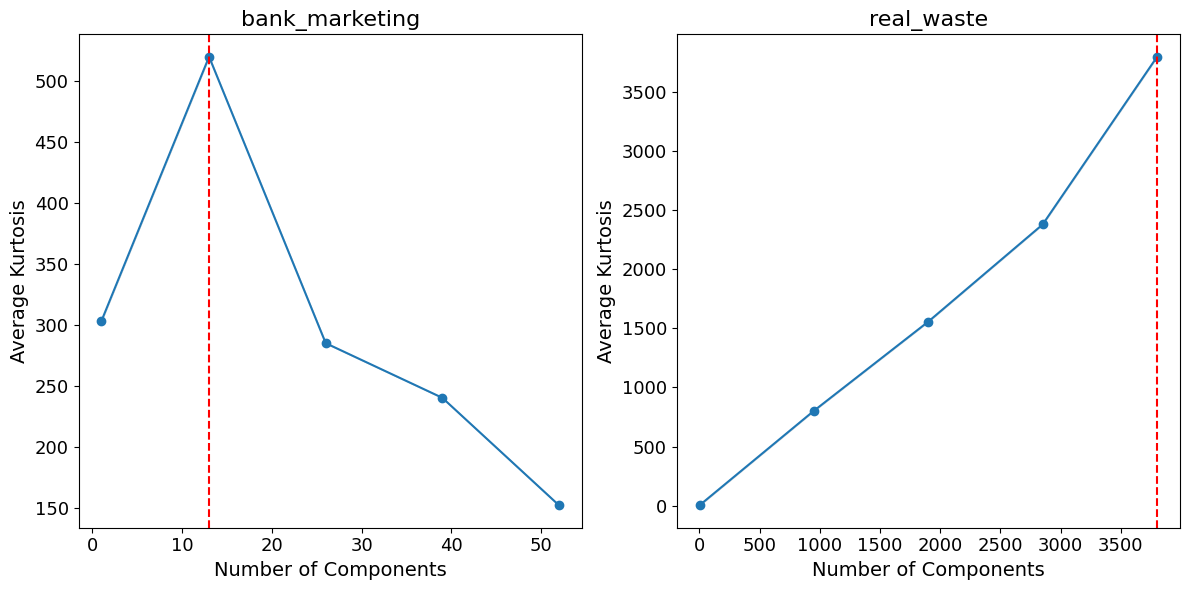

In [82]:
# Finding the latest file
files = glob.glob('ica_kurtosis_*.csv')
latest_file = max(files, key=lambda x: int(x.split('_')[-1].split('.')[0]))
result_df = pd.read_csv(latest_file)

# Get unique dataset names
dataset_names = result_df["dataset_name"].unique()

# Create subplots
fig, axs = plt.subplots(1, len(dataset_names), figsize=(12, 6))

# Plotting
for i, dataset_name in enumerate(dataset_names):
    df = result_df[result_df["dataset_name"] == dataset_name]
    grouped_df = df.groupby('n_components')['avg_kurtosis'].agg(['mean', 'std']).reset_index()


    axs[i].plot(grouped_df["n_components"], grouped_df["mean"], marker='o', label='Mean Average Kurtosis')
    axs[i].fill_between(grouped_df["n_components"], 
                        grouped_df["mean"] - grouped_df["std"], 
                        grouped_df["mean"] + grouped_df["std"], 
                        color='gray', alpha=0.2, label='Standard Deviation')
    axs[i].set_xlabel('Number of Components',fontsize=14)
    axs[i].set_ylabel('Average Kurtosis',fontsize=14)
    axs[i].axvline(x=df.loc[df["avg_kurtosis"].idxmax()]["n_components"], color='r', linestyle='--')
    axs[i].set_title(dataset_name,fontsize=16)
    axs[i].tick_params(axis='both', which='major',labelsize=13)


    print(f'{dataset_name} - {df.loc[df["avg_kurtosis"].idxmax()]["n_components"]}')

plt.tight_layout()
plt.show()

In [59]:
output = []
for _ in range(0,5):
    for dataset_name in ["bank_marketing", "real_waste"]:
        X_train = training_data[dataset_name]["X"]


        for n in np.linspace(1, X_train.shape[1],25,dtype=int):
            transformer = GaussianRandomProjection(n_components=n)
            X_projected = transformer.fit_transform(X_train)
            X_reconstructed = np.dot(X_projected, transformer.components_)
            error = mean_squared_error(X_train, X_reconstructed)

            output.append([dataset_name, n, error])

output_df = pd.DataFrame(output,columns=["dataset_name", "n_components", "reconstruction_error"])
output_df.to_csv(f"rp_reconstruction_error_{time.time()}.csv")

bank_marketing - 9
real_waste - 4096


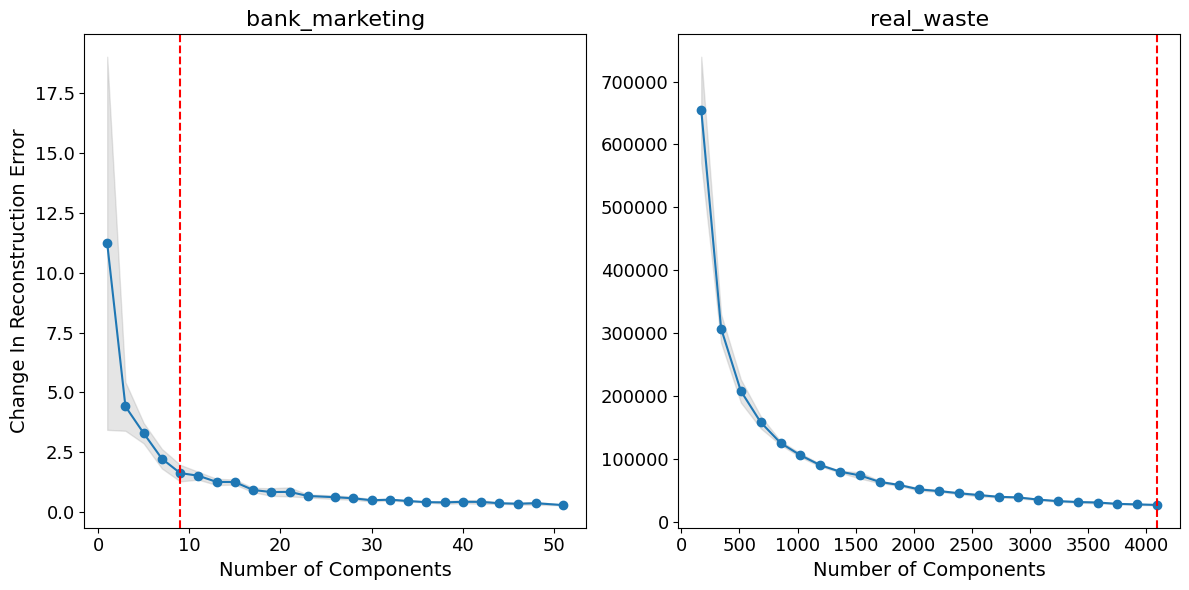

In [68]:
files = glob.glob('rp_reconstruction_*.csv')
latest_file = max(files, key=lambda x: int(x.split('_')[-1].split('.')[0]))
result_df = pd.read_csv(latest_file)

# Get unique dataset names
dataset_names = result_df["dataset_name"].unique()

# Create subplots
fig, axs = plt.subplots(1, len(dataset_names), figsize=(12, 6))

# Plotting
for i, dataset_name in enumerate(dataset_names):
    df = result_df[result_df["dataset_name"] == dataset_name]
    
    # Group by 'n_components' to calculate mean and standard deviation
    grouped_df = df.groupby('n_components')['reconstruction_error'].agg(['mean', 'std']).reset_index()
    grouped_df['mse_derivative'] = grouped_df['mean'].diff()

    # Plot mean reconstruction error and shaded deviation
    axs[i].plot(grouped_df["n_components"], grouped_df["mean"], marker='o', label='Mean Reconstruction Error')
    axs[i].fill_between(grouped_df["n_components"], 
                        grouped_df["mean"] - grouped_df["std"], 
                        grouped_df["mean"] + grouped_df["std"], 
                        color='gray', alpha=0.2)

    axs[i].set_xlabel('Number of Components', fontsize=14)
    if i==0:
        axs[i].set_ylabel('Change In Reconstruction Error', fontsize=14)
    axs[i].set_title(dataset_name, fontsize=16)
    axs[i].tick_params(axis='both', which='major', labelsize=13)

    condition = abs(grouped_df["mse_derivative"]) < 1

    if condition.any():
        min_n_components_row = grouped_df[condition]['n_components'].min()
        axs[i].axvline(x=min_n_components_row, color='r', linestyle='--')
        print(f'{dataset_name} - {min_n_components_row}')
    else:
        axs[i].axvline(x=max(grouped_df['n_components']), color='r', linestyle='--')
        print(f"{dataset_name} - {max(grouped_df['n_components'])}")


plt.tight_layout()
plt.show()

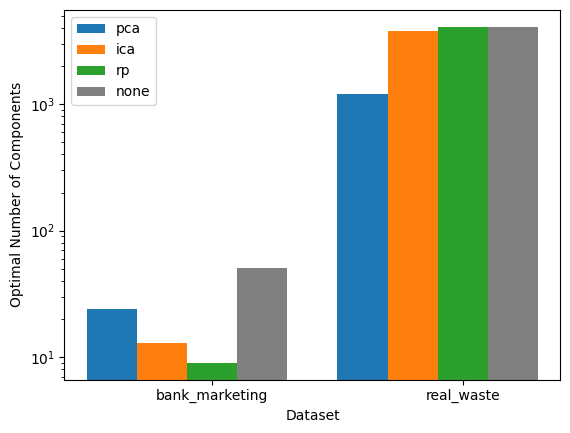

In [8]:
# Numbers copied from print messages of above cells next to graphs.
dim_red_results = {
  "pca": {
   "bank_marketing": 24,
   "real_waste": 1214
  },
  "ica": {
   "bank_marketing": 13,
   "real_waste": 3802
  },
  "rp": {
   "bank_marketing": 9,
   "real_waste": 4096
  },
  "none": {
      "bank_marketing": 51,
      "real_waste": 4096
  }
}

x = np.arange(2)
y1 = [dim_red_results["pca"][key] for key in dim_red_results["pca"].keys()]
y2 = [dim_red_results["ica"][key] for key in dim_red_results["ica"].keys()]
y3 = [dim_red_results["rp"][key] for key in dim_red_results["rp"].keys()]
y4 = [dim_red_results["none"][key] for key in dim_red_results["rp"].keys()]
width = 0.2

plt.bar(x-0.4, y1, width) 
plt.bar(x-0.2, y2, width) 
plt.bar(x, y3, width) 
plt.bar(x+0.2, y4, width,color="grey") 
plt.xticks(x, ['bank_marketing', 'real_waste']) 
plt.xlabel("Dataset") 
plt.ylabel("Optimal Number of Components")
plt.yscale('log')
plt.legend(["pca", "ica", "rp","none"]) 
plt.show() 


In [ ]:
output = []

for _, dim_red, params, dataset_name, n_components in tqdm([(repeat, dim_red,params, dataset_name, n_components) for repeat in range(0,5) for dim_red, params in dim_red_results.items() for dataset_name, n_components in params.items()]):
    X = training_data[dataset_name]["X"]
    y = training_data[dataset_name]["y"]

    start_dim_red_time = time.time()
    if dim_red == "pca":
        model = PCA(n_components=n_components,random_state=RANDOM_SEED)
    elif dim_red == "ica":
        model = FastICA(n_components=n_components, random_state=RANDOM_SEED,max_iter=300)
    elif dim_red == "rp":
        model = GaussianRandomProjection(n_components=n_components,random_state=RANDOM_SEED)
    else: raise
    X_transformed = model.fit_transform(X_train)
    total_dim_red_time = time.time() - start_dim_red_time

    for num_clusters in range(2,11,2):
        for model_name, model in [("KMeans", KMeans(num_clusters,random_state=RANDOM_SEED)), ("EM", GaussianMixture(num_clusters,random_state=RANDOM_SEED))]:
            start_cluster_time = time.time()
            y_pred = model.fit_predict(X_transformed)
            total_cluster_time = time.time() - start_cluster_time

            silhouette_avg = silhouette_score(X_train, y_pred)
            calinski_score = calinski_harabasz_score(X_train, y_pred)

            output.append([dim_red,dataset_name, model_name, num_clusters, n_components, silhouette_avg, calinski_score, total_dim_red_time,total_cluster_time])

            print([dim_red,dataset_name, model_name, num_clusters, n_components, silhouette_avg, calinski_score, total_dim_red_time,total_cluster_time])

output_df = pd.DataFrame(output,columns=["dim_red", "dataset_name", "model_name", "num_clusters", "n_components", "silhouette_avg", "calinski_score", "dim_red_time", "cluster_time"])
output_df.to_csv(f"dim_red_clustering_{time.time()}.csv")

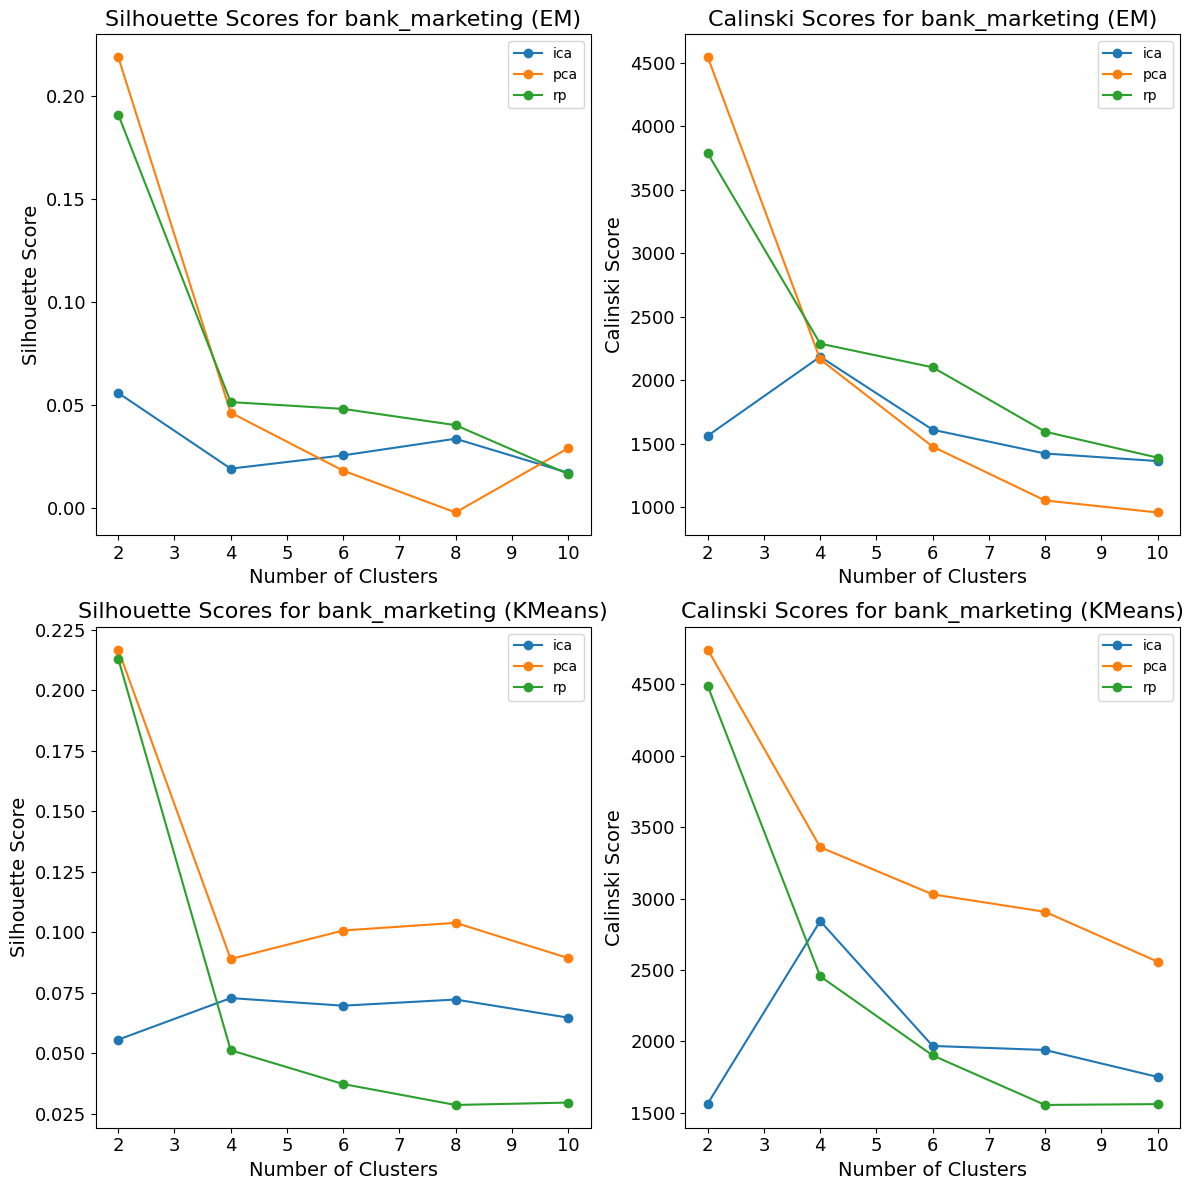

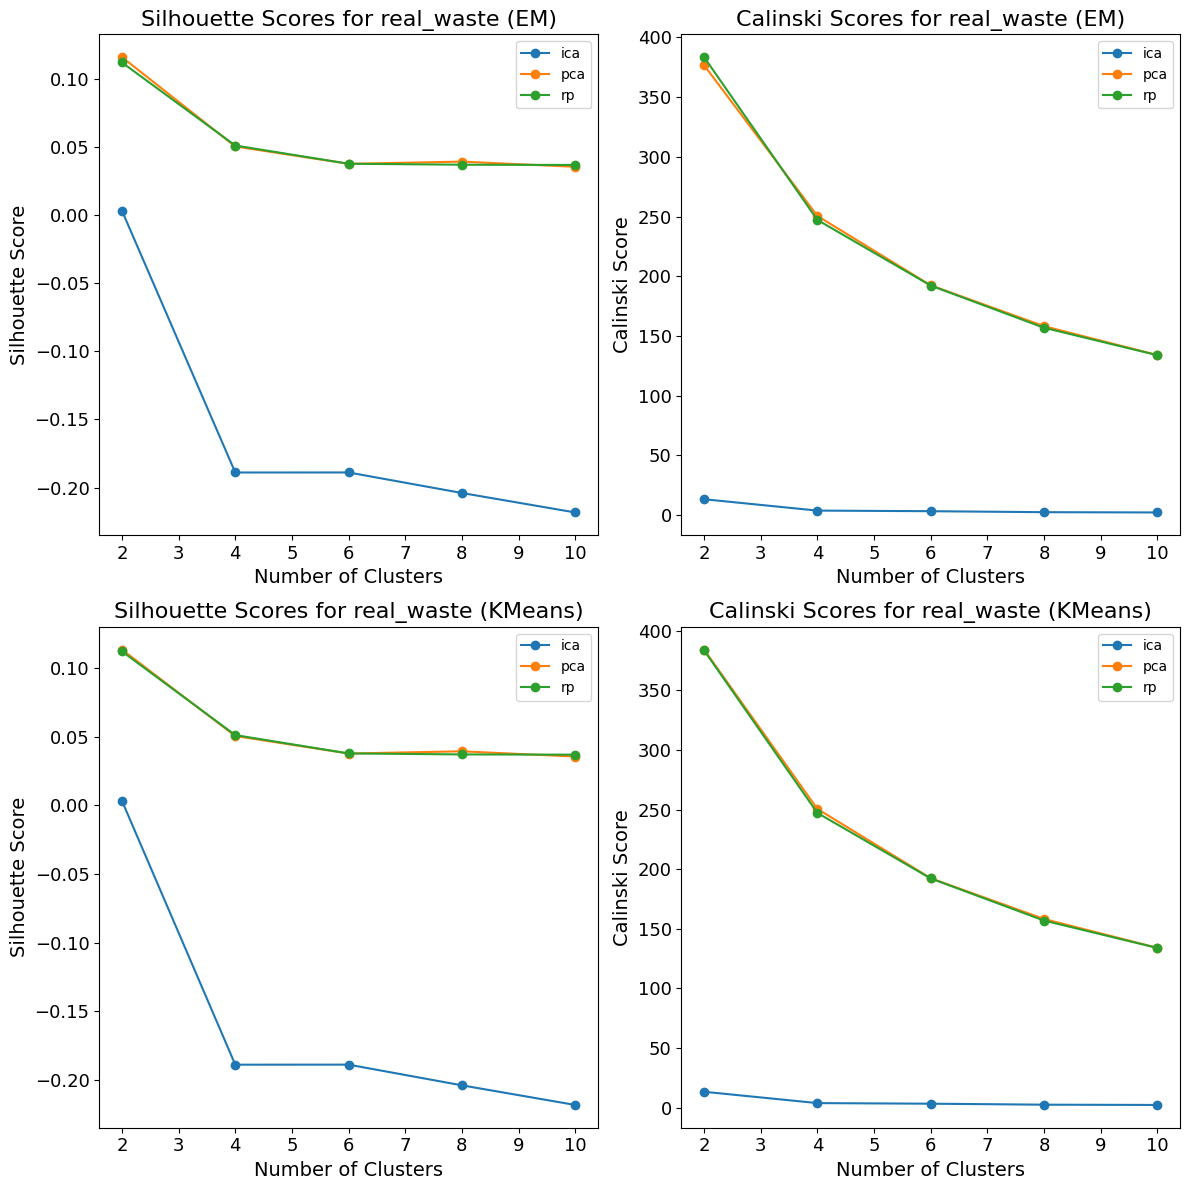

In [75]:
files = glob.glob('dim_red_clustering_*.csv')
latest_file = max(files, key=lambda x: int(x.split('_')[-1].split('.')[0]))
result_df = pd.read_csv(latest_file)

# Function to generate the graphs
def plot_silhouette_and_calinski_scores(df):
    # Get the unique dataset names
    dataset_names = df['dataset_name'].unique()
    
    for dataset in dataset_names:
        # Filter the dataframe by dataset name
        subset = df[df['dataset_name'] == dataset]
        
        # Create subplots
        fig, axs = plt.subplots(2, 2, figsize=(12, 12))
        
        # Plot the silhouette scores
        for (dim_red, model_name), single_df in subset.loc[subset["model_name"]=="EM"].groupby(["dim_red", "model_name"]):
            axs[0][0].plot(single_df['num_clusters'], single_df['silhouette_avg'], marker='o', label=f"{dim_red}")
        
        axs[0][0].set_title(f'Silhouette Scores for {dataset} ({model_name})',fontsize=16)
        axs[0][0].set_xlabel('Number of Clusters', fontsize=14)
        axs[0][0].set_ylabel('Silhouette Score', fontsize=14)
        axs[0][0].tick_params(axis='both', which='major',labelsize=13)
        axs[0][0].legend()
        
        # Plot the calinski scores
        for (dim_red, model_name), single_df in subset.loc[subset["model_name"]=="EM"].groupby(["dim_red", "model_name"]):
            axs[0][1].plot(single_df['num_clusters'], single_df['calinski_score'], marker='o', label=f"{dim_red}")
        
        axs[0][1].set_title(f'Calinski Scores for {dataset} ({model_name})',fontsize=16)
        axs[0][1].set_xlabel('Number of Clusters', fontsize=14)
        axs[0][1].set_ylabel('Calinski Score', fontsize=14)
        axs[0][1].tick_params(axis='both', which='major',labelsize=13)
        axs[0][1].legend()


        for (dim_red, model_name), single_df in subset.loc[subset["model_name"]=="KMeans"].groupby(["dim_red", "model_name"]):
            axs[1][0].plot(single_df['num_clusters'], single_df['silhouette_avg'], marker='o', label=f"{dim_red}")
        
        axs[1][0].set_title(f'Silhouette Scores for {dataset} ({model_name})',fontsize=16)
        axs[1][0].set_xlabel('Number of Clusters', fontsize=14)
        axs[1][0].set_ylabel('Silhouette Score', fontsize=14)
        axs[1][0].tick_params(axis='both', which='major',labelsize=13)
        axs[1][0].legend()
        
        # Plot the calinski scores
        for (dim_red, model_name), single_df in subset.loc[subset["model_name"]=="KMeans"].groupby(["dim_red", "model_name"]):
            axs[1][1].plot(single_df['num_clusters'], single_df['calinski_score'], marker='o', label=f"{dim_red}")
        
        axs[1][1].set_title(f'Calinski Scores for {dataset} ({model_name})',fontsize=16)
        axs[1][1].set_xlabel('Number of Clusters', fontsize=14)
        axs[1][1].set_ylabel('Calinski Score', fontsize=14)
        axs[1][1].tick_params(axis='both', which='major',labelsize=13)
        axs[1][1].legend()
        
        plt.tight_layout()
        plt.show()

plot_silhouette_and_calinski_scores(result_df)

In [9]:
output = []

X_train = training_data["bank_marketing"]["X"]
X_test = testing_data["bank_marketing"]["X"]
y_train = training_data["bank_marketing"]["y"]
y_test = testing_data["bank_marketing"]["y"]


for _, dim_red in tqdm([(repeat, dim_red) for repeat in range(0,5) for dim_red in dim_red_results.keys()]):
    start_time = time.time()
    n_components = dim_red_results[dim_red]["bank_marketing"]

    if dim_red == "pca":
        model = PCA(n_components=n_components)
    elif dim_red == "ica":
        model = FastICA(n_components=n_components,max_iter=300)
    elif dim_red == "rp":
        model = GaussianRandomProjection(n_components=n_components)

    if dim_red != "none":
        X_train_transformed = model.fit_transform(X_train)
        X_test_transformed = model.fit_transform(X_test)
        dim_red_time = time.time() - start_time
    else:
        X_train_transformed = X_train
        X_test_transformed = X_test
        dim_red_time = None

    

    nn_model = MLPClassifier(alpha=0.001, beta_1=0.95, hidden_layer_sizes=(128,), momentum=0.9,max_iter=2000)

    name = "NN"
    start_time = time.time()
    nn_model.fit(X_train_transformed, y_train)
    
    y_pred = nn_model.predict(X_test_transformed)

    nn_time = time.time() - start_time

    # Calculate the F1 score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print([name, dim_red, f1, dim_red_time, nn_time])
    output.append([name, dim_red, f1, dim_red_time, nn_time])
        
output_df = pd.DataFrame(output,columns=["name", "dim_red", "f1", "dim_red_time", "nn_time"])
output_df.to_csv(f"dim_red_nn_{time.time()}.csv")

  5%|▌         | 1/20 [01:02<19:49, 62.58s/it]

['NN', 'pca', 0.7960029964212861, 4.369441986083984, 58.205721855163574]


/Users/timlampen/.pyenv/versions/3.12.2/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
 10%|█         | 2/20 [01:42<14:48, 49.37s/it]

['NN', 'ica', 0.7770564940680611, 9.713635206222534, 30.403738021850586]


 15%|█▌        | 3/20 [02:06<10:42, 37.78s/it]

['NN', 'rp', 0.7798322544383729, 0.0034101009368896484, 23.971858024597168]


 20%|██        | 4/20 [03:11<12:57, 48.59s/it]

['NN', 'none', 0.888583391955456, None, 65.1648497581482]


 25%|██▌       | 5/20 [04:14<13:22, 53.52s/it]

['NN', 'pca', 0.8156779292982109, 4.207102060317993, 58.060770988464355]


 30%|███       | 6/20 [04:56<11:35, 49.67s/it]

['NN', 'ica', 0.8147740054451469, 2.2802300453186035, 39.89699697494507]


 35%|███▌      | 7/20 [05:24<09:13, 42.59s/it]

['NN', 'rp', 0.8048805565902046, 0.006207942962646484, 27.993436813354492]


 40%|████      | 8/20 [06:46<11:03, 55.30s/it]

['NN', 'none', 0.8864331903316834, None, 82.50817084312439]


 45%|████▌     | 9/20 [07:45<10:19, 56.30s/it]

['NN', 'pca', 0.8061226246611091, 4.146188020706177, 54.36933612823486]


 50%|█████     | 10/20 [08:28<08:43, 52.35s/it]

['NN', 'ica', 0.8019731905047669, 2.372300863265991, 41.116169929504395]


 55%|█████▌    | 11/20 [08:54<06:38, 44.25s/it]

['NN', 'rp', 0.6909304661768657, 0.006417989730834961, 25.881688833236694]


 60%|██████    | 12/20 [09:59<06:43, 50.38s/it]

['NN', 'none', 0.889216939146356, None, 64.3924732208252]


 65%|██████▌   | 13/20 [10:51<05:56, 50.93s/it]

['NN', 'pca', 0.8203083737535625, 4.095873117446899, 48.07876682281494]


/Users/timlampen/.pyenv/versions/3.12.2/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
 70%|███████   | 14/20 [11:38<04:58, 49.78s/it]

['NN', 'ica', 0.8171273662189216, 10.027275085449219, 37.09835076332092]


 75%|███████▌  | 15/20 [12:00<03:26, 41.30s/it]

['NN', 'rp', 0.730289743434022, 0.006697893142700195, 21.62947416305542]


 80%|████████  | 16/20 [12:55<03:02, 45.58s/it]

['NN', 'none', 0.8898622813593366, None, 55.51635694503784]


 85%|████████▌ | 17/20 [13:58<02:32, 50.72s/it]

['NN', 'pca', 0.7942121132002391, 4.503726959228516, 58.17948508262634]


/Users/timlampen/.pyenv/versions/3.12.2/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
 90%|█████████ | 18/20 [14:40<01:36, 48.29s/it]

['NN', 'ica', 0.7700952705376302, 9.750601053237915, 32.873384952545166]


 95%|█████████▌| 19/20 [14:58<00:39, 39.19s/it]

['NN', 'rp', 0.8094013319799571, 0.007384061813354492, 17.971069812774658]


100%|██████████| 20/20 [16:03<00:00, 48.15s/it]

['NN', 'none', 0.8909015079748429, None, 64.11676788330078]


/var/folders/v3/kzkfzr0d6vs5bm72nlpk67_c0000gn/T/ipykernel_9181/2519806359.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = result_df.groupby('dim_red').agg({'f1': ['mean', 'std'], 'total_time': ['mean', 'std']})


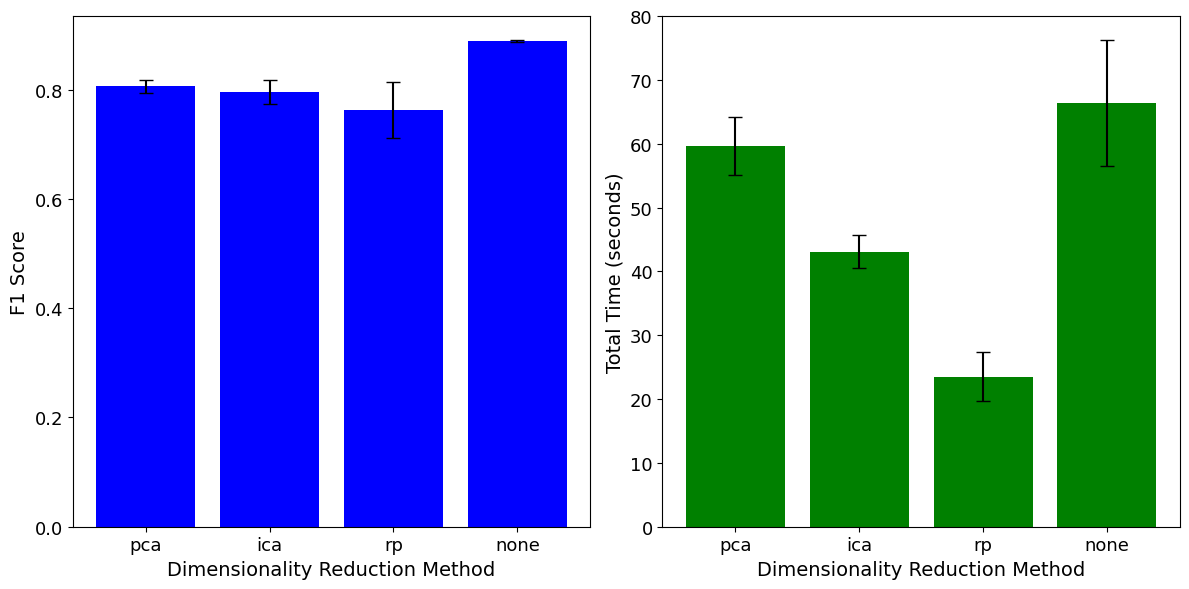

In [12]:
files = glob.glob('dim_red_nn_*.csv')
latest_file = max(files, key=lambda x: int(x.split('_')[-1].split('.')[0]))
result_df = pd.read_csv(latest_file)


# Handle the None value in 'dim_red_time' column by replacing it with 0 for calculation purposes
result_df['dim_red_time'] = result_df['dim_red_time'].fillna(0)

# Create the combined time column
result_df['total_time'] = result_df['dim_red_time'] + result_df['nn_time']
result_df['dim_red'] = pd.Categorical(result_df['dim_red'], categories=['pca', 'ica', 'rp', 'none'], ordered=True)

grouped = result_df.groupby('dim_red').agg({'f1': ['mean', 'std'], 'total_time': ['mean', 'std']})

# Create the bar charts
f1_means = grouped['f1']['mean']
f1_stds = grouped['f1']['std']
time_means = grouped['total_time']['mean']
time_stds = grouped['total_time']['std']

# Create the bar charts with error bars
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot the f1-score chart
axes[0].bar(f1_means.index, f1_means, yerr=f1_stds, color='blue', capsize=5)
axes[0].set_xlabel('Dimensionality Reduction Method', fontsize=14)
axes[0].set_ylabel('F1 Score', fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=13)

# Plot the total time chart
axes[1].bar(time_means.index, time_means, yerr=time_stds, color='green', capsize=5)
axes[1].set_xlabel('Dimensionality Reduction Method', fontsize=14)
axes[1].set_ylabel('Total Time (seconds)', fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=13)

plt.tight_layout()
plt.show()

In [13]:
output = []

X_train = training_data["bank_marketing"]["X"]
X_test = testing_data["bank_marketing"]["X"]
y_train = training_data["bank_marketing"]["y"]
y_test = testing_data["bank_marketing"]["y"]


for _, dim_red in tqdm([(repeat, dim_red) for repeat in range(0,5) for dim_red in dim_red_results.keys()]):
    start_time = time.time()
    n_components = 15 # fixed

    if dim_red == "pca":
        model = PCA(n_components=n_components)
    elif dim_red == "ica":
        model = FastICA(n_components=n_components,max_iter=300)
    elif dim_red == "rp":
        model = GaussianRandomProjection(n_components=n_components)

    if dim_red != "none":
        X_train_transformed = model.fit_transform(X_train)
        X_test_transformed = model.fit_transform(X_test)
        dim_red_time = time.time() - start_time
    else:
        X_train_transformed = X_train
        X_test_transformed = X_test
        dim_red_time = None

    

    nn_model = MLPClassifier(alpha=0.001, beta_1=0.95, hidden_layer_sizes=(128,), momentum=0.9,max_iter=2000)

    name = "NN"
    start_time = time.time()
    nn_model.fit(X_train_transformed, y_train)
    
    y_pred = nn_model.predict(X_test_transformed)

    nn_time = time.time() - start_time

    # Calculate the F1 score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print([name, dim_red, f1, dim_red_time, nn_time])
    output.append([name, dim_red, f1, dim_red_time, nn_time])
        
output_df = pd.DataFrame(output,columns=["name", "dim_red", "f1", "dim_red_time", "nn_time"])
output_df.to_csv(f"dim_red_fixed_15_nn_{time.time()}.csv")

  5%|▌         | 1/20 [00:53<17:03, 53.86s/it]

['NN', 'pca', 0.8163647420860595, 3.651686906814575, 50.20153284072876]


 10%|█         | 2/20 [01:46<15:58, 53.26s/it]

['NN', 'ica', 0.7317967846534543, 11.356369018554688, 41.477893114089966]


 15%|█▌        | 3/20 [02:17<12:13, 43.12s/it]

['NN', 'rp', 0.6504756637652545, 0.006897926330566406, 31.045164823532104]


 20%|██        | 4/20 [03:24<13:56, 52.27s/it]

['NN', 'none', 0.8866738482729153, None, 66.28446412086487]


 25%|██▌       | 5/20 [04:25<13:54, 55.65s/it]

['NN', 'pca', 0.8162857476685021, 3.8172919750213623, 57.81482911109924]


 30%|███       | 6/20 [05:10<12:06, 51.89s/it]

['NN', 'ica', 0.7164937774362073, 3.9320859909057617, 40.64967608451843]


 35%|███▌      | 7/20 [05:42<09:51, 45.52s/it]

['NN', 'rp', 0.7854433373989602, 0.00725102424621582, 32.39714026451111]


 40%|████      | 8/20 [06:37<09:41, 48.48s/it]

['NN', 'none', 0.8902041920111897, None, 54.831501722335815]


 45%|████▌     | 9/20 [07:23<08:43, 47.60s/it]

['NN', 'pca', 0.808442106823418, 3.6314940452575684, 42.018595933914185]


 50%|█████     | 10/20 [08:22<08:31, 51.15s/it]

['NN', 'ica', 0.7490763383344268, 4.494237184524536, 54.59670400619507]


 55%|█████▌    | 11/20 [09:01<07:08, 47.66s/it]

['NN', 'rp', 0.6458507420774725, 0.012948274612426758, 39.70934772491455]


 60%|██████    | 12/20 [11:01<09:15, 69.46s/it]

['NN', 'none', 0.8899690954940643, None, 119.32916402816772]


 65%|██████▌   | 13/20 [12:15<08:17, 71.01s/it]

['NN', 'pca', 0.8114730765242454, 3.704437017440796, 70.84806680679321]


 70%|███████   | 14/20 [13:28<07:08, 71.50s/it]

['NN', 'ica', 0.7042314095804177, 15.533872842788696, 57.08980393409729]


 75%|███████▌  | 15/20 [14:43<06:02, 72.43s/it]

['NN', 'rp', 0.6335670990068529, 0.006253957748413086, 74.57522201538086]


 80%|████████  | 16/20 [16:41<05:44, 86.23s/it]

['NN', 'none', 0.8904231413615492, None, 118.25666785240173]


 85%|████████▌ | 17/20 [17:44<03:57, 79.18s/it]

['NN', 'pca', 0.8160646523412253, 4.637815952301025, 58.14555597305298]


 90%|█████████ | 18/20 [18:47<02:28, 74.33s/it]

['NN', 'ica', 0.7879609095455156, 6.993963003158569, 56.04508686065674]


 95%|█████████▌| 19/20 [20:06<01:15, 75.78s/it]

['NN', 'rp', 0.8258181021868566, 0.008877038955688477, 79.1221570968628]


100%|██████████| 20/20 [21:58<00:00, 65.95s/it]

['NN', 'none', 0.892224221097626, None, 112.5743842124939]


/var/folders/v3/kzkfzr0d6vs5bm72nlpk67_c0000gn/T/ipykernel_9181/2487528386.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = result_df.groupby('dim_red').agg({'f1': ['mean', 'std'], 'total_time': ['mean', 'std']})


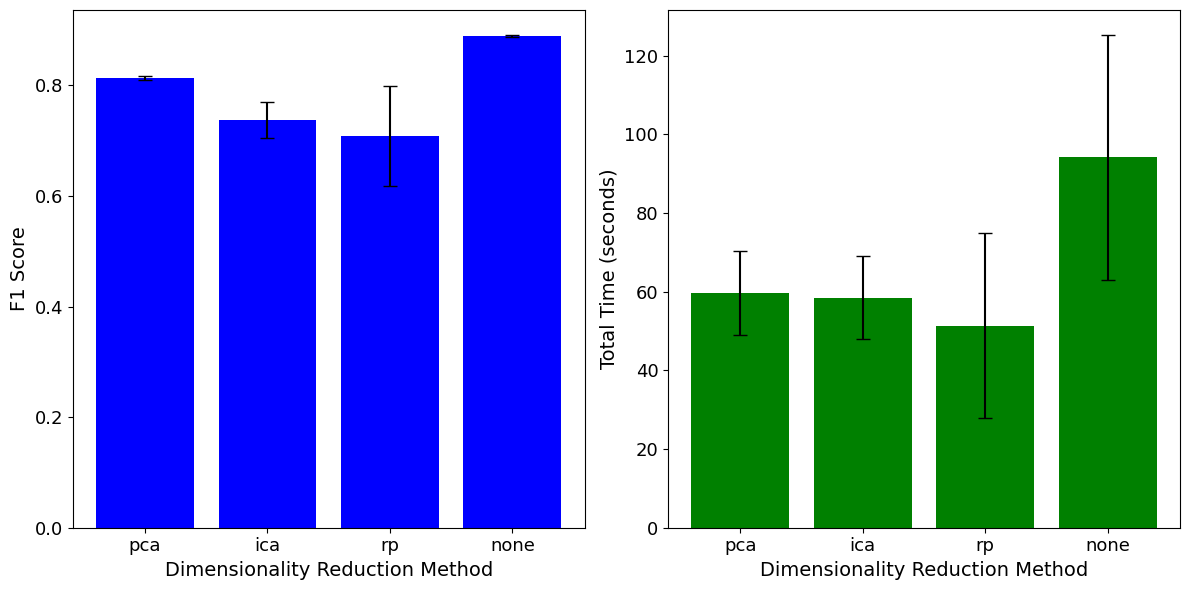

In [36]:
files = glob.glob('dim_red_fixed_15_nn*.csv')
latest_file = max(files, key=lambda x: int(x.split('_')[-1].split('.')[0]))
result_df = pd.read_csv(latest_file)


# Handle the None value in 'dim_red_time' column by replacing it with 0 for calculation purposes
result_df['dim_red_time'] = result_df['dim_red_time'].fillna(0)

# Create the combined time column
result_df['total_time'] = result_df['dim_red_time'] + result_df['nn_time']
result_df['dim_red'] = pd.Categorical(result_df['dim_red'], categories=['pca', 'ica', 'rp', 'none'], ordered=True)

grouped = result_df.groupby('dim_red').agg({'f1': ['mean', 'std'], 'total_time': ['mean', 'std']})

# Create the bar charts
f1_means = grouped['f1']['mean']
f1_stds = grouped['f1']['std']
time_means = grouped['total_time']['mean']
time_stds = grouped['total_time']['std']

# Create the bar charts with error bars
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot the f1-score chart
axes[0].bar(f1_means.index, f1_means, yerr=f1_stds, color='blue', capsize=5)
axes[0].set_xlabel('Dimensionality Reduction Method', fontsize=14)
axes[0].set_ylabel('F1 Score', fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=13)

# Plot the total time chart
axes[1].bar(time_means.index, time_means, yerr=time_stds, color='green', capsize=5)
axes[1].set_xlabel('Dimensionality Reduction Method', fontsize=14)
axes[1].set_ylabel('Total Time (seconds)', fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=13)

plt.tight_layout()
plt.show()

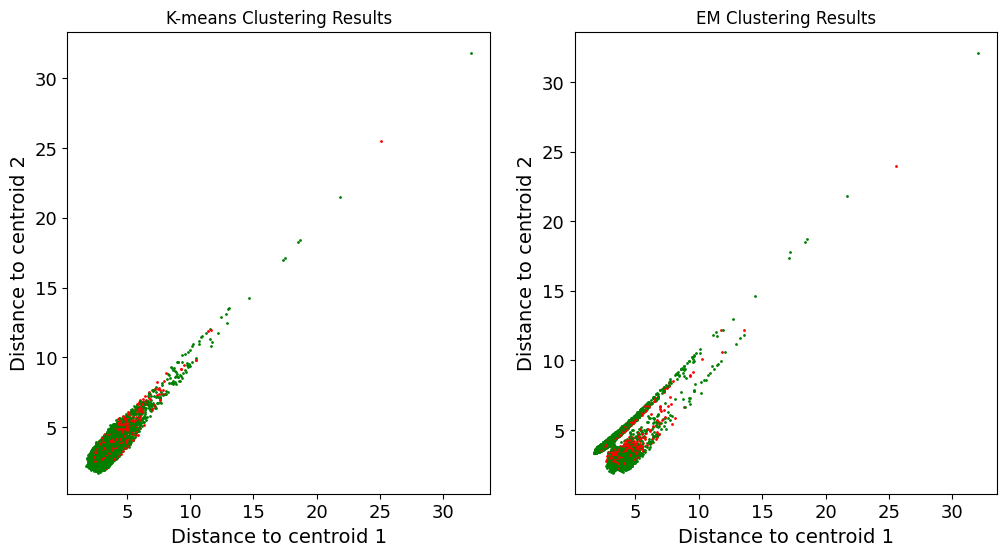

(0.8229037448063268, 0.8228486780387366)

In [15]:
def train_evaluate_mlp_classifier():
    # Split the data into training and testing sets
    X_train = training_data["bank_marketing"]["X"]
    X_test = testing_data["bank_marketing"]["X"]
    y_train = training_data["bank_marketing"]["y"]
    y_test = testing_data["bank_marketing"]["y"]
    y_test = list(y_test)
    
    def transform_data_with_clusters(model, X_train, X_test):
        model.fit(X_train)
        centroids = model.cluster_centers_
        X_train_transformed = np.array([np.linalg.norm(x - centroids, axis=1) for x in X_train])
        X_test_transformed = np.array([np.linalg.norm(x - centroids, axis=1) for x in X_test])
        return X_train_transformed, X_test_transformed

    # K-means clustering
    kmeans = KMeans(n_clusters=2)
    X_train_kmeans, X_test_kmeans = transform_data_with_clusters(kmeans, X_train, X_test)

    # Expectation Maximization (Gaussian Mixture Model) clustering
    gmm = GaussianMixture(n_components=2)
    gmm.fit(X_train)
    centroids_gmm = gmm.means_
    X_train_gmm = np.array([np.linalg.norm(x - centroids_gmm, axis=1) for x in X_train])
    X_test_gmm = np.array([np.linalg.norm(x - centroids_gmm, axis=1) for x in X_test])

    # Train MLPClassifier on the transformed data
    mlp_kmeans = MLPClassifier()
    mlp_kmeans.fit(X_train_kmeans, y_train)
    y_pred_kmeans = mlp_kmeans.predict(X_test_kmeans)

    mlp_gmm = MLPClassifier()
    mlp_gmm.fit(X_train_gmm, y_train)
    y_pred_gmm = mlp_gmm.predict(X_test_gmm)

    # Calculate F1 scores
    f1_kmeans = f1_score(y_test, y_pred_kmeans, average='weighted')
    f1_gmm = f1_score(y_test, y_pred_gmm, average='weighted')

    def plot_results(X_test_transformed, y_test, y_pred, title, ax):
        for i in range(len(y_test)):
            color = 'green' if y_test[i] == y_pred[i] else 'red'
            ax.scatter(X_test_transformed[i][0], X_test_transformed[i][1], color=color, s=1)
        ax.set_title(title)
        ax.set_xlabel('Distance to centroid 1',fontsize=14)
        ax.set_ylabel('Distance to centroid 2',fontsize=14)
        ax.tick_params(axis='both', which='major',labelsize=13)


    # Create a figure with two subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    plot_results(X_test_kmeans, y_test, y_pred_kmeans, 'K-means Clustering Results', axs[0])
    plot_results(X_test_gmm, y_test, y_pred_gmm, 'EM Clustering Results', axs[1])

    plt.show()

    return f1_kmeans, f1_gmm



train_evaluate_mlp_classifier()

In [32]:
model = GaussianMixture(n_components=2)
model.fit(X_train)
centroids = model.means_
X_train_transformed = np.array([np.linalg.norm(x - centroids, axis=1) for x in X_train])
X_test_transformed = np.array([np.linalg.norm(x - centroids, axis=1) for x in X_test])
